In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tempfile
import pyabc

import healpy as hp
from scipy.special import sph_harm
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
from dipole import cmb_dipole
import generate_mocks as gm

### toy model

documentation: https://pyabc.readthedocs.io/en/latest/examples/parameter_inference.html

In [3]:
# simple Gaussian model, single parameter = mean (mu), fixed variance (0.5)
def model(parameter):
    return {"data": parameter["mu"] + 0.5 * np.random.randn()}

In [4]:
# uniform prior on mu from 0-5
prior = pyabc.Distribution(mu=pyabc.RV("uniform", 0, 5))  # note third argument is the _width_, not the upper bound

In [5]:
# distance between the simulated and real data: in this case, the absolute difference
def distance(x, x0):
    return abs(x["data"] - x0["data"])

From the documentation:

Now we create the ABCSMC object, the main inference class. It defines an ABC-SMC algorithm, which sequentially generates particle populations of size $N$, sampling in generation $t$ from a perturbation of accepted particles in generation $t-1$ via importance samling, thus from a successively improved posterior approximation, thus allowing to gradually reduce an acceptance threshold $\varepsilon$ on the permitted distance, while maintaining high acceptance rates.

In [6]:
# now create the ABCSMC object: generates populations of size N by randomly sampling from the prior
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)

ABC.Sampler INFO: Parallelize sampling on 48 processes.


In [7]:
# specify where to log the ABC-SMC runs (pyABC uses an SQL database (?))
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = 2.5 # the REAL data -> if we observed a value of mu=2.5
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.History INFO: Start <ABCSMC id=1, start_time=2024-12-20 19:56:53>


In [8]:
# start the sampling: sample until the acceptance threshold drops below 0.1, and specify a max of 10 populations
# *whichever is reached first, the acceptance threshold drops below 0.1, or the max populations, will stop the sampling
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.25107764e+00.
ABC INFO: Accepted: 1000 / 1953 = 5.1203e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.23416562e-01.
ABC INFO: Accepted: 1000 / 2307 = 4.3346e-01, ESS: 9.3570e+02.
ABC INFO: t: 2, eps: 3.21910464e-01.
ABC INFO: Accepted: 1000 / 3300 = 3.0303e-01, ESS: 6.6800e+02.
ABC INFO: t: 3, eps: 1.61811439e-01.
ABC INFO: Accepted: 1000 / 5860 = 1.7065e-01, ESS: 6.7369e+02.
ABC INFO: t: 4, eps: 7.91992992e-02.
ABC INFO: Accepted: 1000 / 12450 = 8.0321e-02, ESS: 5.6291e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:49.353145, end_time=2024-12-20 19:57:42>


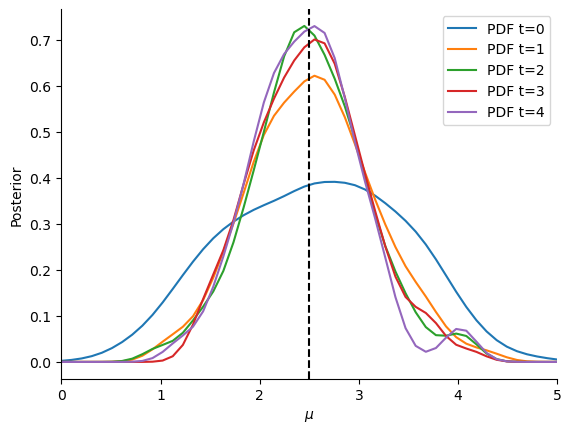

In [9]:
# visualize the results
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=5,
        x="mu",
        xname=r"$\mu$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(observation, color="k", linestyle="dashed")
ax.legend()

## functions

In [3]:
def dipole(theta, phi, dipole_x, dipole_y, dipole_z):
    """
    Return the signal contribution from the dipole at a certain sky location (theta,phi).
    """
    return dipole_x * np.sin(theta)*np.cos(phi) + dipole_y * np.sin(theta) * np.sin(phi) + dipole_z * np.cos(theta)

In [4]:
def dipole_map(amps, NSIDE=64):
    """
    Generate a healpix dipole map (equatorial coordinates) given four parameters:
       the monopole plus three dipole amplitudes.
       
    Bugs/Comments:
    - amps is a 4-vector because we suck.
    """
    NPIX = hp.nside2npix(NSIDE)  # number of pixels
    theta, phi = hp.pix2ang(NSIDE, ipix=np.arange(NPIX))  # get (theta,phi) coords of each pixel
    dip = dipole(theta, phi, *amps[1:])  # expected dipole: shape==(NPIX,)
    return amps[0] + dip

In [5]:
def real_sph_harm(m, ell, theta, phi):
    """
    Return a real basis of the spherical harmonics given `ell`, `m`, and a set of angles `(theta,phi)`.
    """
    if m < 0:
        res = (1j * np.sqrt(1/2) * \
               (sph_harm(-np.abs(m), ell, phi, theta) - (-1)**m * sph_harm(np.abs(m), ell, phi, theta))).real
    elif m > 0:
        res = np.sqrt(1/2) * \
                (sph_harm(-np.abs(m), ell, phi, theta) + (-1)**m * sph_harm(np.abs(m), ell, phi, theta)).real
    else:
        assert m == 0
        res = sph_harm(m, ell, phi, theta).real
    return res

In [6]:
def multipole_map(amps, NSIDE=64):
    """
    Return a healpix map of a multipole given input amplitude of each component `amps`.
    The input `amps` must be ordered in increasing m, i.e. -ell to ell.
    """
    amps = np.array(amps)
    assert amps.ndim <= 1
    if amps.ndim == 0:
        amps = amps[...,np.newaxis]
    assert len(amps) % 2 == 1
    ell = (len(amps) - 1) // 2
    ms = np.linspace(-ell, ell, len(amps))
    NPIX = hp.nside2npix(NSIDE)
    theta, phi = hp.pix2ang(NSIDE, ipix=np.arange(NPIX))
    hpmap = np.zeros(NPIX)
    for i, m in enumerate(ms):
        comp = real_sph_harm(m, ell, theta, phi)
        hpmap += amps[i] * comp
    return hpmap

In [7]:
def get_kde_1d(abc, parameter):
    df, w = abc.history.get_distribution()
    return pyabc.visualization.kde.kde_1d(pd.concat((df[parameter],), axis=1), w, df[parameter].name,
                           xmin=abc.parameter_priors[0][parameter].args[0],
                           xmax=abc.parameter_priors[0][parameter].args[0] + abc.parameter_priors[0][parameter].args[1])

In [8]:
def get_kde_2d(abc, parameter1, parameter2):
    df, w = abc.history.get_distribution()
    return pyabc.visualization.kde.kde_2d(pd.concat((df[parameter1], df[parameter2]), axis=1), w, df[parameter1].name, df[parameter2].name,
                            xmin=abc.parameter_priors[0][parameter1].args[0],
                            xmax=abc.parameter_priors[0][parameter1].args[0] + abc.parameter_priors[0][parameter1].args[1],
                            ymin=abc.parameter_priors[0][parameter2].args[0],
                            ymax=abc.parameter_priors[0][parameter2].args[0] + abc.parameter_priors[0][parameter2].args[1])

In [9]:
def scatter(abc, parameter1, parameter2, ax, **kwargs):
    df, w = abc.history.get_distribution()
    ax.scatter(df[par_ids[i]], df[par_ids[j]], **kwargs)
    ax.set_xlim(abc.parameter_priors[0][parameter1].args[0],
                abc.parameter_priors[0][parameter1].args[0] + abc.parameter_priors[0][parameter1].args[1])
    ax.set_ylim(abc.parameter_priors[0][parameter2].args[0],
                abc.parameter_priors[0][parameter2].args[0] + abc.parameter_priors[0][parameter2].args[1])

## a simple model

Imagine the data is dipole + shot noise, galactic plane mask, and we want to infer the dipole amplitude.

In [10]:
def model(parameters):
    """
    Generates a healpix density map with dipole in fixed CMB dipole direction.

    Parameters
    ----------
    parameters : dict
        keys:
            "dipole_amp" = dipole amplitude
            "base_rate" = quasar density base rate

    Returns
    -------
    Quasar overdensity map of NSIDE=1.
    
    """
    
    rng = np.random.default_rng(seed=None) # should I put a seed in here??
    blim = 30
    nside = 1

    # expected dipole map
    amps = np.zeros(4)
    amps[1:] = cmb_dipole(amplitude=parameters["dipole_amp"], return_amps=True)
    expected_dipole_map = dipole_map(amps, NSIDE=nside)

    # galactic plane mask
    mask = tools.get_galactic_plane_mask(blim, nside=64, frame='icrs')
    mask_dg = hp.ud_grade(mask, nside)

    # poisson sample, including the base rate and the selfunc map
    overdensity_map = rng.poisson((1. + expected_dipole_map) * parameters["base_rate"] * mask_dg)

    return { "data" : overdensity_map }

In [14]:
# construct "real" data
nside = 64
base_rate = 33.64
amps = np.array([0., *cmb_dipole(amplitude=0.0052, return_amps=True)])
rng = np.random.default_rng(seed=None)
qmap = rng.poisson((1. + dipole_map(amps, NSIDE=nside)) * base_rate * tools.get_galactic_plane_mask(30, nside=nside, frame='icrs'))
qmap_dg = hp.ud_grade(qmap, 1, power=-2)

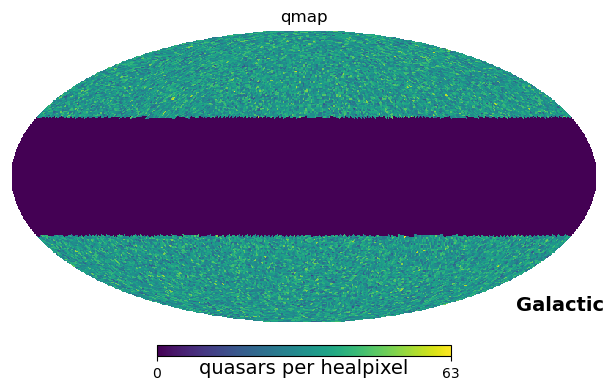

In [15]:
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap, coord=['C','G'], sub=(1,2,1), unit='quasars per healpixel', title='qmap')

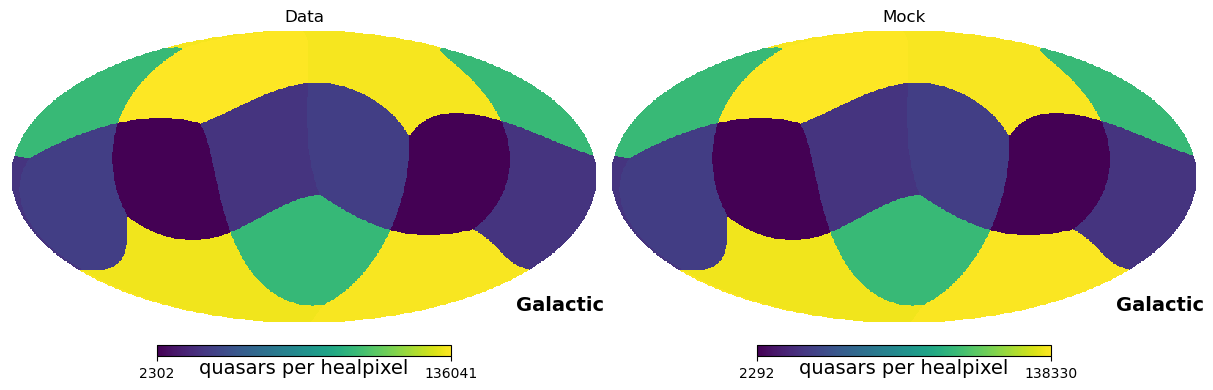

In [23]:
# compare real and example mock
mock = model(dict(dipole_amp=.004, base_rate=1.4e5))
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap_dg, coord=['C','G'], sub=(1,2,1), unit='quasars per healpixel', title='Data')
hp.mollview(mock['data'], coord=['C','G'], sub=(1,2,2), unit='quasars per healpixel', title='Mock')

In [41]:
expected_dipole_amp = 0.0052
prior = pyabc.Distribution(dipole_amp = pyabc.RV("uniform", 0., 3 * expected_dipole_amp),
                           base_rate = pyabc.RV("uniform", 1.37e5, 2e3))  # note much higher base rate since healpixels are much bigger

In [42]:
def distance(x, x0):
    return sum((x["data"] - x0["data"])**2)

In [43]:
# perform the parameter inference
abc = pyabc.ABCSMC(model, prior, distance, population_size=100)

# history
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = qmap_dg
abc.new("sqlite:///" + db_path, {"data": observation})

# start the sampling!
history = abc.run(minimum_epsilon=10, max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 48 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2024-12-21 12:45:09>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.95601750e+06.
ABC INFO: Accepted: 100 / 202 = 4.9505e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.07113100e+06.
ABC INFO: Accepted: 100 / 349 = 2.8653e-01, ESS: 9.4435e+01.
ABC INFO: t: 2, eps: 1.55424622e+06.
ABC INFO: Accepted: 100 / 376 = 2.6596e-01, ESS: 6.0973e+01.
ABC INFO: t: 3, eps: 1.19159760e+06.
ABC INFO: Accepted: 100 / 891 = 1.1223e-01, ESS: 2.3487e+01.
ABC INFO: t: 4, eps: 1.00732861e+06.
ABC INFO: Accepted: 100 / 914 = 1.0941e-01, ESS: 9.3903e+01.
ABC INFO: t: 5, eps: 8.13330667e+05.
ABC INFO: Accepted: 100 / 1155 = 8.6580e-02, ESS: 7.5057e+01.
ABC INFO: t: 6, eps: 6.76966740e+05.
ABC INFO: Accepted: 100 / 1955 = 5.1151e-02, ESS: 8.0472e+01.
ABC INFO: t: 7, eps: 5.09561286e+05.
ABC INFO: Accepted: 100 / 4775 = 2.0942e-02, ESS: 4.8033e+01.
ABC INFO: t: 8, eps: 3.84629658e+05.
ABC INFO: Acc

Text(0.5, 1.02, 'ABC posteriors: "data" = 0.0052 dipole amp, no excess power')

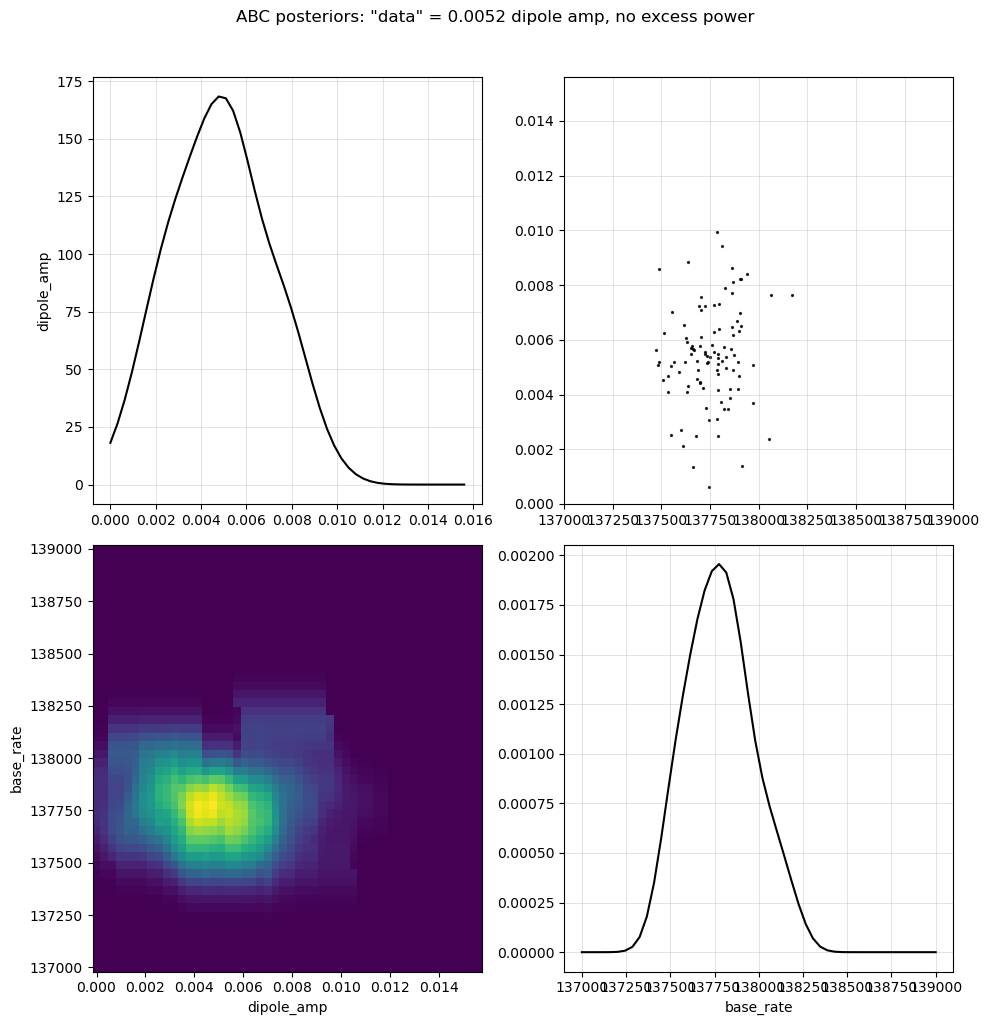

In [49]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = ["dipole_amp", "base_rate"]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,10), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(abc, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(abc, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(abc, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors: "data" = {expected_dipole_amp} dipole amp, no excess power', y=1.02)

## our model with Quaia!

#### test downgrading

In [11]:
# selection function
selfunc = hp.read_map(f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits')

/ext3/miniconda3/lib/python3.10/site-packages/healpy/visufunc.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/ext3/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


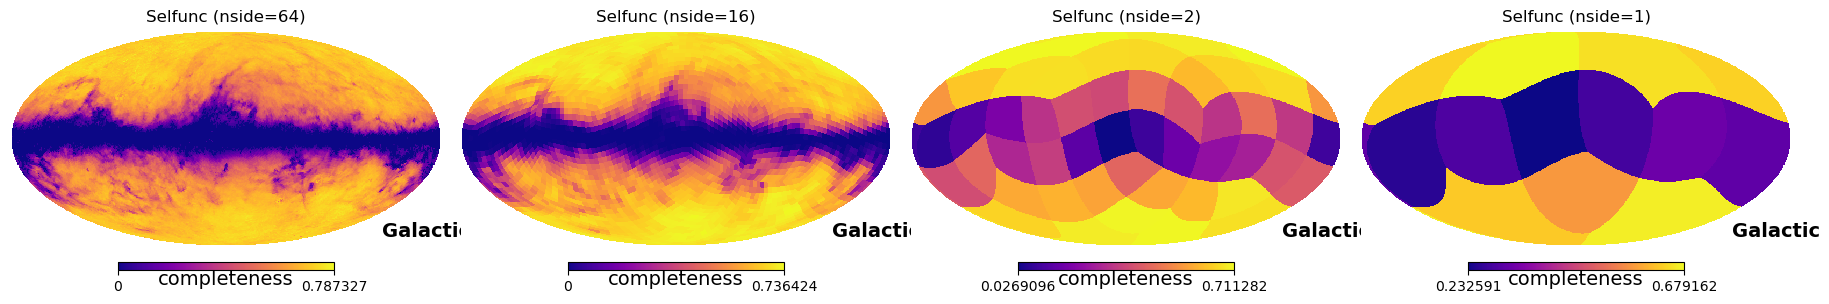

In [12]:
nsides = [16, 2, 1]
fig = plt.figure(figsize=(6*len(nsides),3), tight_layout=True)
hp.mollview(selfunc, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,1), title='Selfunc (nside=64)', unit='completeness')
for i, nside in enumerate(nsides):
    selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)
    hp.mollview(selfunc_dg, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,i+2), title=f'Selfunc (nside={nside})', unit='completeness')

In [13]:
# masks
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
mask = small_masks * tools.get_galactic_plane_mask(30, nside=hp.npix2nside(len(small_masks)), frame='icrs')

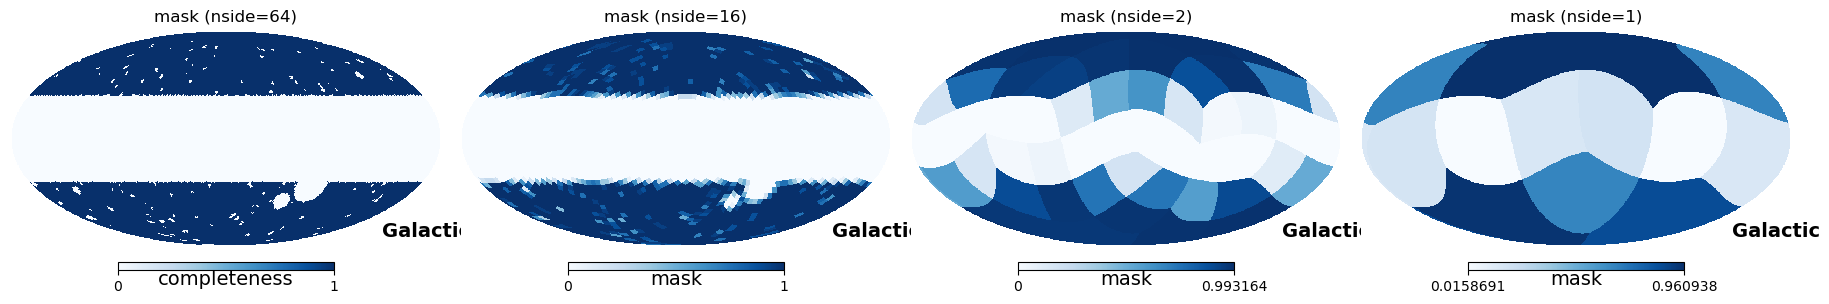

In [14]:
nsides = [16, 2, 1]
fig = plt.figure(figsize=(6*len(nsides),3), tight_layout=True)
hp.mollview(mask, coord=['C','G'], cmap='Blues', sub=(1,len(nsides)+1,1), title='mask (nside=64)', unit='completeness')
for i, nside in enumerate(nsides):
    mask_dg = hp.pixelfunc.ud_grade(mask, nside)
    hp.mollview(mask_dg, coord=['C','G'], cmap='Blues', sub=(1,len(nsides)+1,i+2), title=f'mask (nside={nside})', unit='mask')

In [15]:
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
gal_plane_mask = tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
selfunc = hp.read_map(selfunc_fn) * small_masks * gal_plane_mask

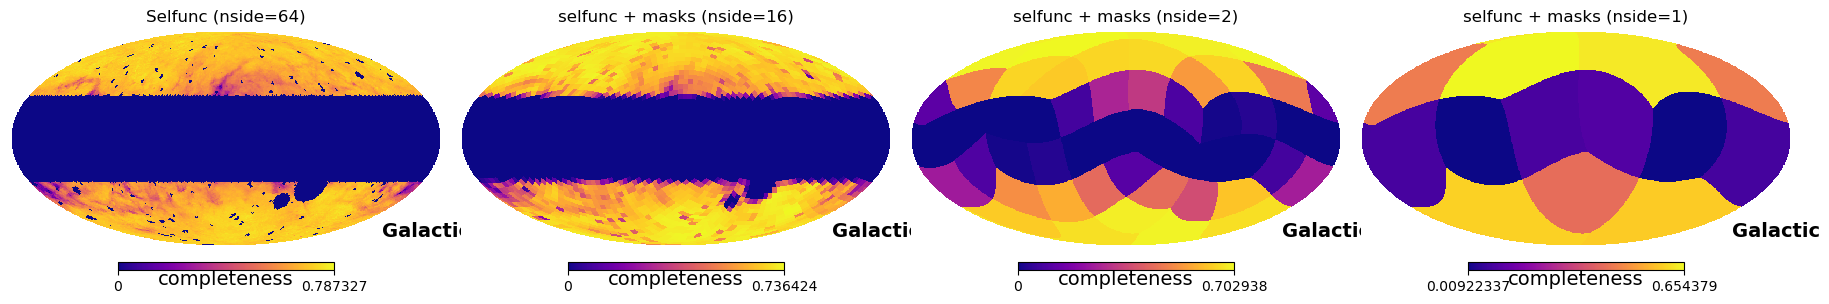

In [17]:
nsides = [16, 2, 1]
fig = plt.figure(figsize=(6*len(nsides),3), tight_layout=True)
hp.mollview(selfunc, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,1), title='Selfunc (nside=64)', unit='completeness')
for i, nside in enumerate(nsides):
    selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)
    hp.mollview(selfunc_dg, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,i+2), title=f'selfunc + masks (nside={nside})', unit='completeness')

#### downgrade the pixel resolution but keep the sum of the pixel values independent of `NSIDE`

In [18]:
nside1 = 16
nside2 = 1
rng = np.random.default_rng(seed=127)
base = 10
testmap = rng.poisson(base * np.ones(hp.nside2npix(nside1)))
ntotal = sum(testmap)
print(f"{ntotal} total quasars")

30683 total quasars


In [19]:
# downgrade
testmap_dg = hp.ud_grade(testmap, nside2, power=-2) # power = -2 keeps the sum invariant!!

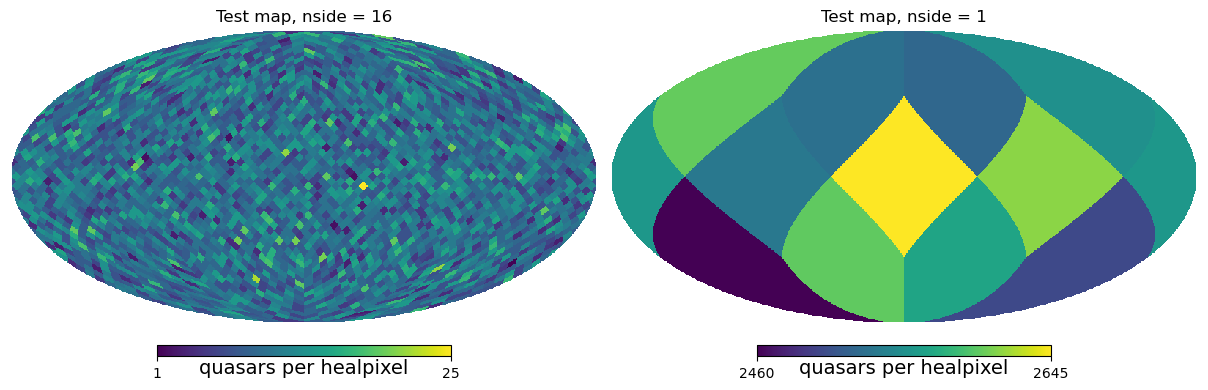

In [20]:
fig = plt.figure(figsize=(12,4))
hp.mollview(testmap, unit='quasars per healpixel', title=f'Test map, nside = {nside1}', sub=(1,2,1))
hp.mollview(testmap_dg, unit='quasars per healpixel', title=f'Test map, nside = {nside2}', sub=(1,2,2))

In [21]:
sum(testmap), sum(testmap_dg)

(30683, 30683)

In [22]:
# yes!!

In [23]:
# selection function
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
# downsample and add galactic plane mask
selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

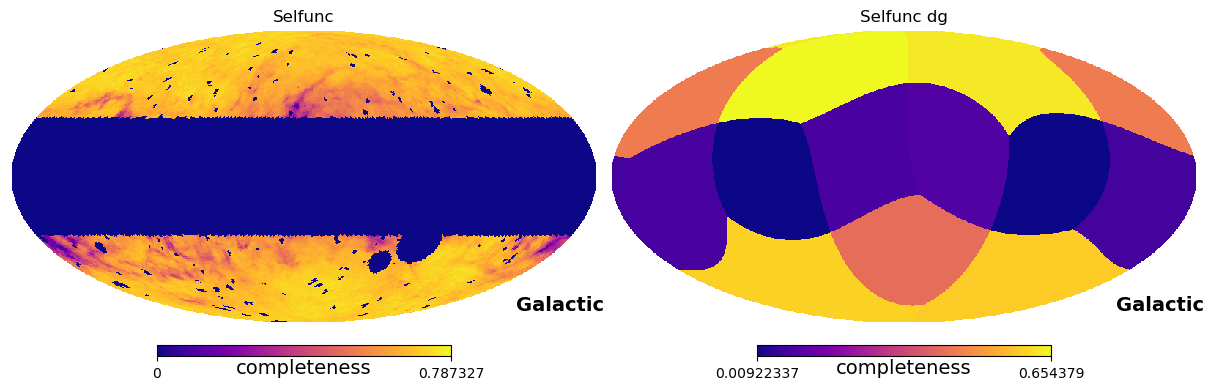

In [25]:
fig = plt.figure(figsize=(12,4))
hp.mollview(selfunc, coord=['C','G'], unit='completeness', title='Selfunc', cmap='plasma', sub=(1,2,1))
hp.mollview(selfunc_dg, coord=['C','G'], unit='completeness', title='Selfunc dg', cmap='plasma', sub=(1,2,2))

In [26]:
sum(selfunc), sum(selfunc_dg)

(15153.812230362631, 3.6996611890533972)

#### define data, model, prior and distance

In [27]:
# data
fn_cat = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/quaia_G20.0.fits'
qmap_raw = tools.load_catalog_as_map(fn_cat, frame='icrs', nside=64)
# add galactic plane mask
qmap = qmap_raw * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
qmap_dg = hp.ud_grade(qmap, 1, power=-2)

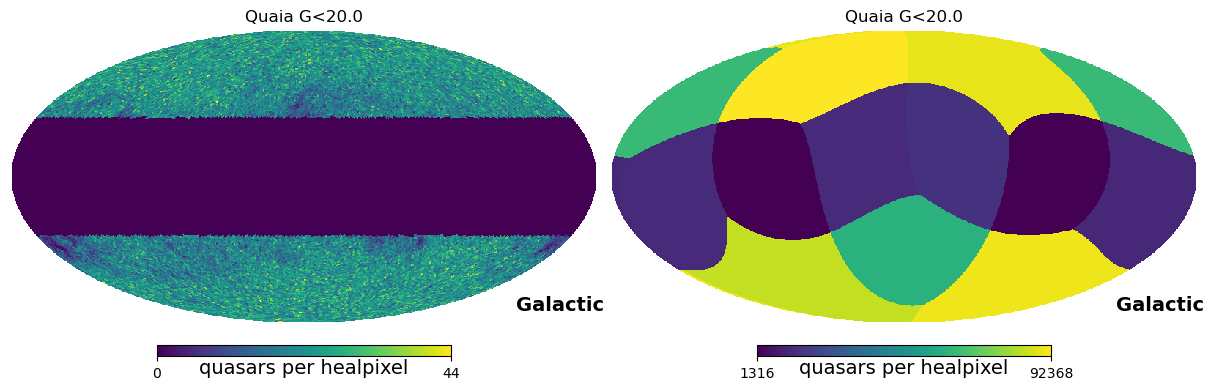

In [28]:
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap, coord=['C','G'], unit='quasars per healpixel', title='Quaia G<20.0', sub=(1,2,1))
hp.mollview(qmap_dg, coord=['C','G'], unit='quasars per healpixel', title='Quaia G<20.0', sub=(1,2,2))

In [29]:
def model(parameters):
    """
    Generates a healpix density map with dipole in fixed CMB dipole direction.

    Parameters
    ----------
    parameters : dict
        keys:
            "dipole_amp" = dipole amplitude
            "log_excess" = log of the excess power (flat in Cell)
            "base_rate" = quasar density base rate

    Returns
    -------
    Quasar overdensity map of NSIDE=1.
    
    """
    
    rng = np.random.default_rng(seed=None) # should I put a seed in here??
    nside = 1
    blim = 30

    # selection function
    small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
    selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
    selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(blim, nside=64, frame='icrs')
    # downsample
    selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

    # expected dipole map
    amps = np.zeros(4)
    amps[1:] = cmb_dipole(amplitude=parameters["dipole_amp"], return_amps=True)
    expected_dipole_map = dipole_map(amps, NSIDE=nside)

    # add Cells
    # Cells: flat, determined by input log_excess
    Cells = np.zeros(8) + 10**parameters["log_excess"]
    # draw alms from a Gaussian
    sph_harm_amp_dict = {}
    for ell in range(1, len(Cells)+1):
        sph_harm_amp_dict[ell] = np.sqrt(Cells[ell-1]) * rng.normal(size=2 * ell + 1)
    # then make map from the alms
    excess_map = np.zeros((hp.nside2npix(nside)))
    for ell in sph_harm_amp_dict.keys():
        alms = sph_harm_amp_dict[ell]
        assert len(alms) == 2 * ell + 1, \
            f"incorrect number of coefficients for ell={ell} ({len(alms)}, expected {2 * ell + 1}"
        excess_map += multipole_map(alms, NSIDE=nside)

    # smooth overdensity map
    smooth_overdensity_map = expected_dipole_map + excess_map

    # poisson sample, including the base rate and the selfunc map
    overdensity_map = rng.poisson((1. + smooth_overdensity_map) * parameters["base_rate"] * selfunc_dg)

    return { "data" : overdensity_map }

In [30]:
expected_dipole_amp = 0.0052
prior = pyabc.Distribution(dipole_amp = pyabc.RV("uniform", 0., 3 * expected_dipole_amp),
                           log_excess = pyabc.RV("uniform", -6, 3),
                           base_rate = pyabc.RV("uniform", 1.35e5, 1.5e4))  # note much higher base rate since healpixels are much bigger

In [31]:
def distance(x, x0):
    #assert len(x["data"]) == len(x0["data"])
    #assert x["data"].ndim == x0["data"].ndim
    return sum((x["data"] - x0["data"])**2)

#### perform the parameter inference

In [32]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100)

ABC.Sampler INFO: Parallelize sampling on 48 processes.


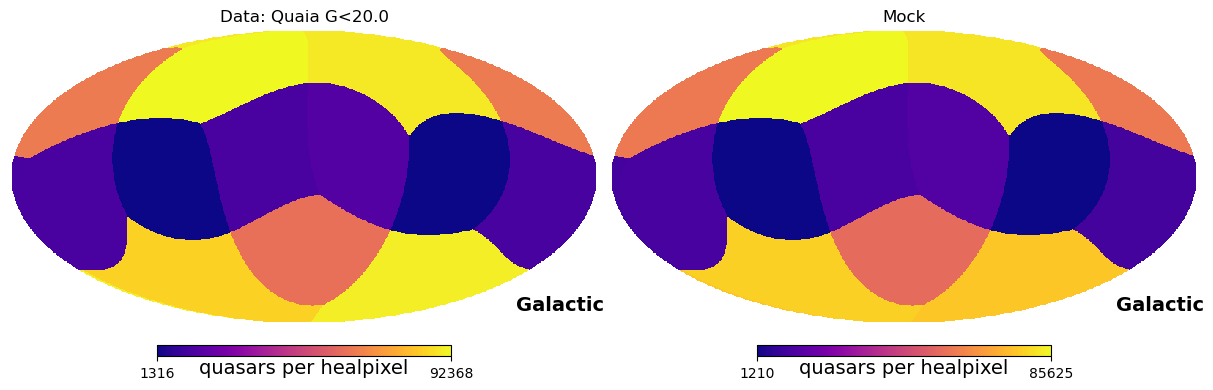

In [33]:
# compare data and mock as a sanity check
mock = model(dict(dipole_amp=0.0052, log_excess=-5, base_rate=1.3e5))["data"]
fig = plt.figure(figsize=(12,4), tight_layout=True)
hp.mollview(qmap_dg, coord=['C','G'], cmap='plasma', sub=(1,2,1), title='Data: Quaia G<20.0', unit='quasars per healpixel')
hp.mollview(mock, coord=['C','G'], cmap='plasma', sub=(1,2,2), title='Mock', unit='quasars per healpixel')

In [34]:
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = qmap_dg
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.History INFO: Start <ABCSMC id=1, start_time=2024-12-21 16:08:45>


In [35]:
# start the sampling!
history = abc.run(minimum_epsilon=10, max_nr_populations=12)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.11348078e+08.
ABC INFO: Accepted: 100 / 211 = 4.7393e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 7.29912200e+07.
ABC INFO: Accepted: 100 / 257 = 3.8911e-01, ESS: 7.6877e+01.
ABC INFO: t: 2, eps: 5.86974277e+07.
ABC INFO: Accepted: 100 / 387 = 2.5840e-01, ESS: 7.5571e+01.
ABC INFO: t: 3, eps: 5.35833117e+07.
ABC INFO: Accepted: 100 / 445 = 2.2472e-01, ESS: 8.6628e+01.
ABC INFO: t: 4, eps: 4.67943227e+07.
ABC INFO: Accepted: 100 / 868 = 1.1521e-01, ESS: 7.7451e+01.
ABC INFO: t: 5, eps: 4.04863322e+07.
ABC INFO: Accepted: 100 / 1706 = 5.8617e-02, ESS: 8.0374e+01.
ABC INFO: t: 6, eps: 3.45102213e+07.
ABC INFO: Accepted: 100 / 3166 = 3.1586e-02, ESS: 7.0506e+01.
ABC INFO: t: 7, eps: 2.95920436e+07.
ABC INFO: Accepted: 100 / 4128 = 2.4225e-02, ESS: 6.6137e+01.
ABC INFO: t: 8, eps: 2.44628222e+07.
ABC INFO: Accepted: 100 / 7939 = 1.2596e-02, ESS: 8.0674e+01.
ABC INFO: t: 9, eps: 2.04632404e+07.
ABC INFO: Accepted: 100 / 11754 = 8.5077

Text(0.5, 0.98, 'ABC posteriors')

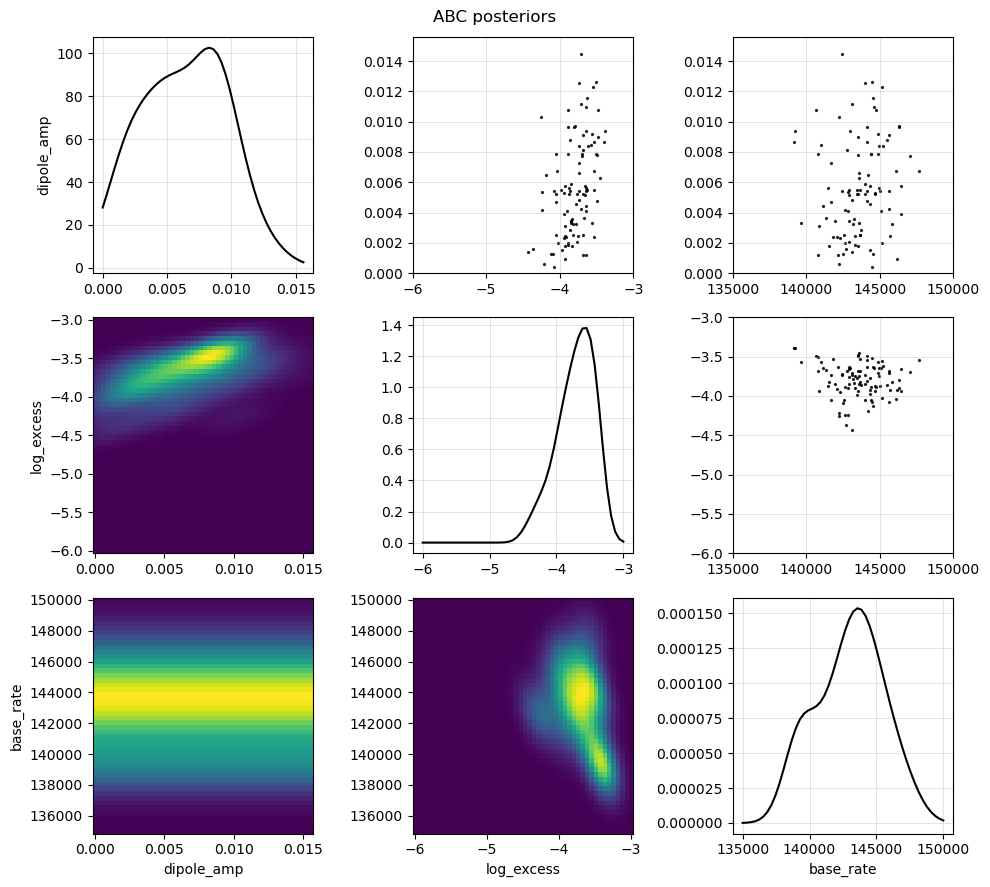

In [39]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = ['dipole_amp', 'log_excess', 'base_rate']
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(abc, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(abc, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(abc, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors')

/ext3/miniconda3/lib/python3.10/site-packages/healpy/visufunc.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/ext3/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


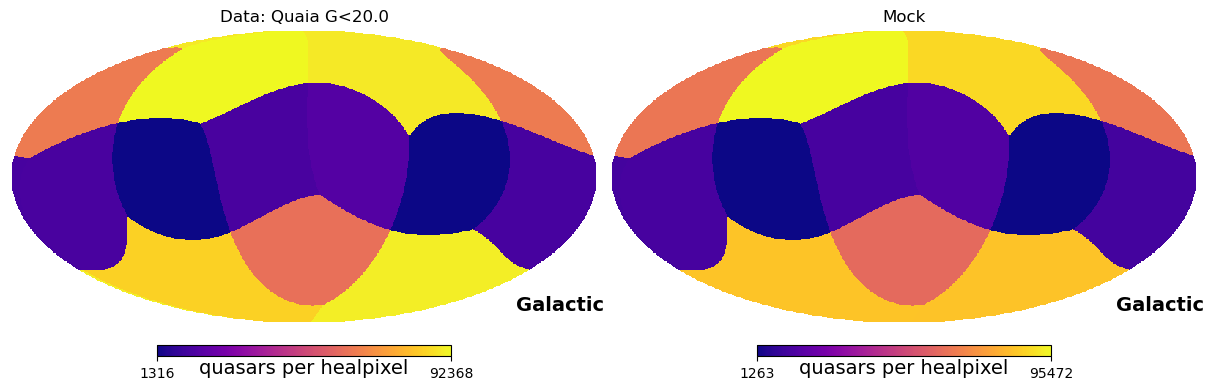

In [69]:
# pull an accepted mock and compare to the input data:
mock_pars = history.get_distribution()[0].iloc[0] # just get the first row of the data frame
mock_map = model(dict(dipole_amp=mock_pars['dipole_amp'], log_excess=mock_pars['log_excess'], base_rate=mock_pars['base_rate']))['data']
fig = plt.figure(figsize=(12,4), tight_layout=True)
hp.mollview(qmap_dg, coord=['C','G'], cmap='plasma', sub=(1,2,1), title='Data: Quaia G<20.0', unit='quasars per healpixel')
hp.mollview(mock_map, coord=['C','G'], cmap='plasma', sub=(1,2,2), title='Mock', unit='quasars per healpixel')

Text(0.5, 1.0, 'Epsilon evolution')

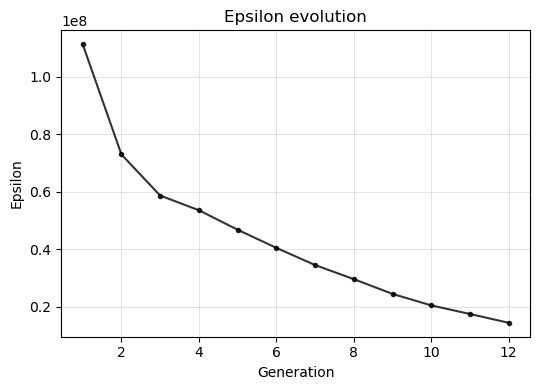

In [53]:
# evolution of epsilon
fig, ax = plt.subplots(figsize=(5.5,4), tight_layout=True)
epsilons = history.get_all_populations()['epsilon'][1:] # note first entry is from calibration and must be discarded
ax.plot(epsilons, c='k', marker='.', alpha=0.8)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Generation')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon evolution')

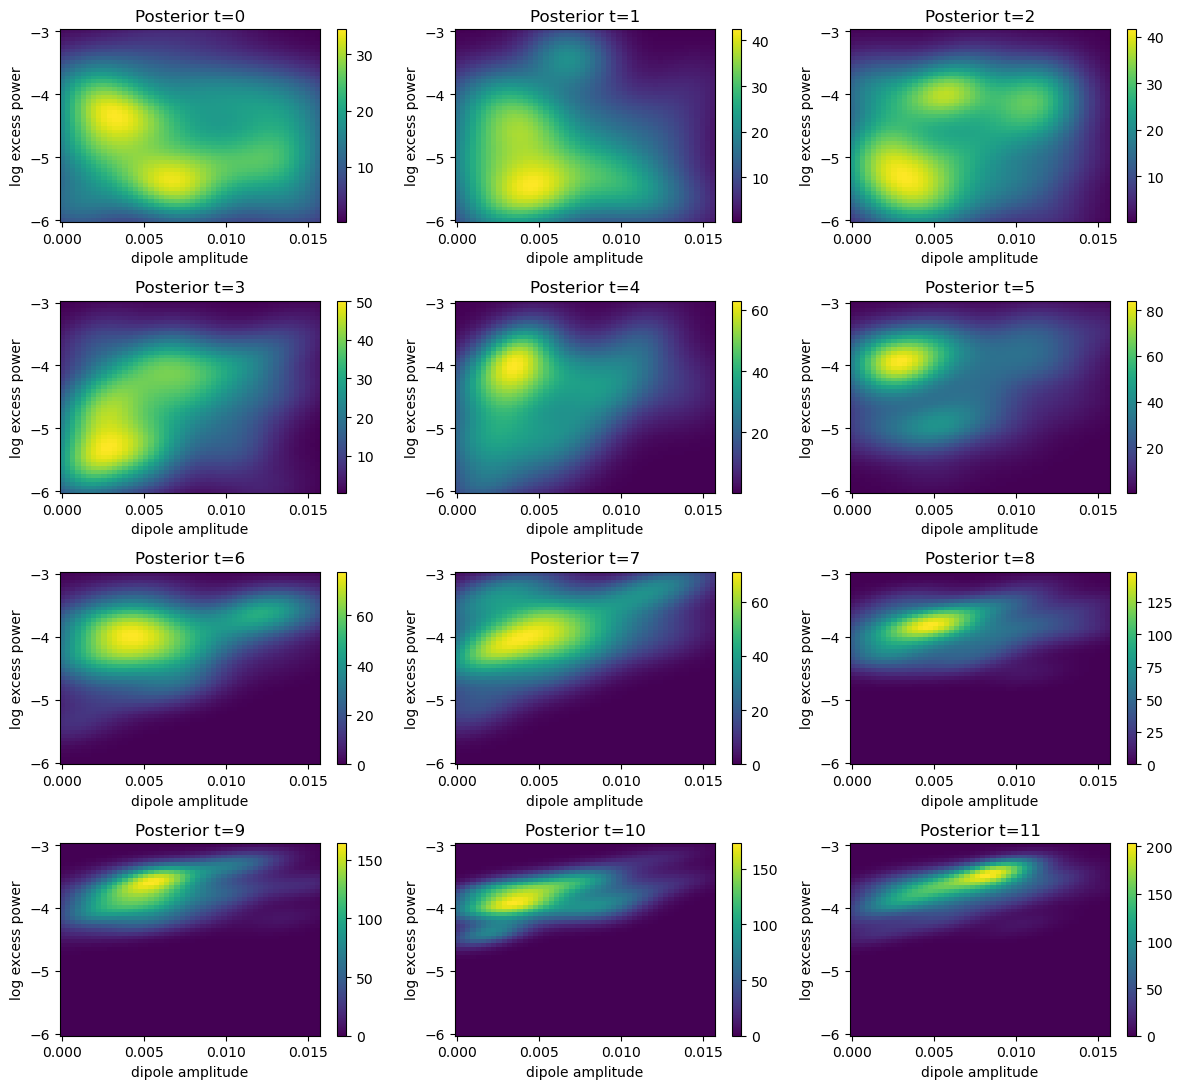

In [57]:
# visualize
fig = plt.figure(figsize=(12, 11), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot(int(np.ceil(history.max_t / 3)), 3, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=abc.parameter_priors[0]['dipole_amp'].args[0],
        xmax=abc.parameter_priors[0]['dipole_amp'].args[0] + abc.parameter_priors[0]['dipole_amp'].args[1],
        y="log_excess",
        yname=r"log excess power",
        ymin=abc.parameter_priors[0]['log_excess'].args[0],
        ymax=abc.parameter_priors[0]['log_excess'].args[0] + abc.parameter_priors[0]['log_excess'].args[1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

In [58]:
# how do these temporary files work?
saved_history = pyabc.storage.History("sqlite:///" + db_path)
saved_history

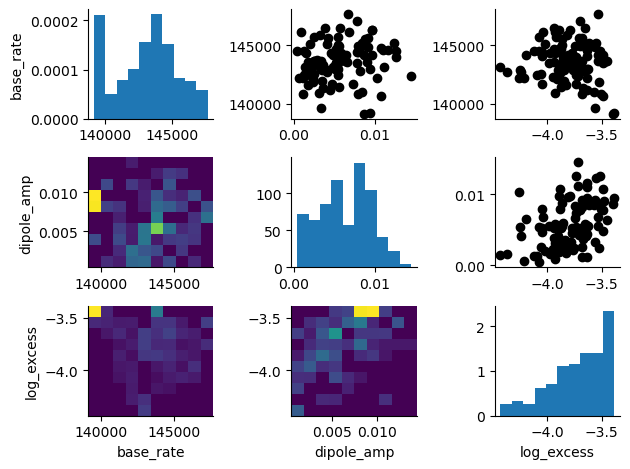

In [59]:
axs = pyabc.visualization.plot_histogram_matrix(history)